In [1]:
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import src.learning as lrn
%load_ext autoreload
%matplotlib widget

# Reachable Set Training

## Load and Check Data Distributions

In [10]:
base_dir = "../saved/controllable_set/reachset_train/20231115-025054"
data_random = np.load(os.path.join(base_dir, "data_random.npy"))
data_structured = np.load(os.path.join(base_dir, "data_structured.npy"))

In [3]:
# print shapes
print(f"Random data shape: {data_random.shape}")
print(f"Structured data shape: {data_structured.shape}")

# print bounds for each column
names = ["h", "vx", "vz", "m", "tgo", "x_xmax", "y_xmax", "x_xmin", "y_xmin", "x_ymax", "y_ymax"]
for data in [data_structured, data_random]:
    print("Structured" if data is data_structured else "Random")
    for i in range(data.shape[1]):
        print(f"{names[i]}: [{np.min(data[:, i]):.2f}, {np.max(data[:, i]):.2f}]")

Random data shape: (68140, 11)
Structured data shape: (20585, 11)
Structured
h: [52.13, 1652.98]
vx: [0.33, 55.95]
vz: [-96.25, 84.99]
m: [1545.91, 1903.23]
tgo: [9.60, 149.80]
x_xmax: [4.19, 217.62]
y_xmax: [0.00, 0.00]
x_xmin: [-217.62, 217.45]
y_xmin: [0.00, 0.00]
x_ymax: [-0.00, 217.50]
y_ymax: [0.18, 217.62]
Random
h: [14.14, 1692.93]
vx: [0.00, 56.02]
vz: [-99.95, 86.24]
m: [1552.94, 1904.57]
tgo: [10.00, 150.00]
x_xmax: [1.86, 222.88]
y_xmax: [0.00, 0.00]
x_xmin: [-222.80, 216.48]
y_xmin: [0.00, 0.00]
x_ymax: [-0.00, 217.52]
y_ymax: [0.95, 222.80]


In [4]:
reachset = np.vstack((data_structured, data_random))
print(f"Reachset shape: {reachset.shape}")

Reachset shape: (88725, 11)


In [5]:
xmin_, xmax_, ymax_, x_ymax_ = lrn.transform_reachsetparam(
    xmin=reachset[:, 5], 
    xmax=reachset[:, 7], 
    ymax=reachset[:, 10], 
    x_ymax=reachset[:, 9], 
    alt=reachset[:, 0],
    )

# print max and min for xmin_, xmax_, ymax_, x_ymax_
print(f"xmin_: [{np.min(xmin_):.2f}, {np.max(xmin_):.2f}]")
print(f"xmax_: [{np.min(xmax_):.2f}, {np.max(xmax_):.2f}]")
print(f"ymax_: [{np.min(ymax_):.2f}, {np.max(ymax_):.2f}]")
print(f"x_ymax_: [{np.min(x_ymax_):.2f}, {np.max(x_ymax_):.2f}]")

xmin_: [0.65, 0.98]
xmax_: [0.02, 0.98]
ymax_: [0.01, 0.95]
x_ymax_: [0.50, 0.98]


In [6]:
alt_, vx_, vz_, z_, tgo_ = lrn.transform_ic(
    alt=reachset[:, 0],
    vx=reachset[:, 1],
    vz=reachset[:, 2],
    z=np.log(reachset[:, 3]),
    tgo=reachset[:, 4],
    )

# print max and min for alt_, vx_, vz_, z_, tgo_
print(f"alt_: [{np.min(alt_):.2f}, {np.max(alt_):.2f}]")
print(f"vx_: [{np.min(vx_):.2f}, {np.max(vx_):.2f}]")
print(f"vz_: [{np.min(vz_):.2f}, {np.max(vz_):.2f}]")
print(f"z_: [{np.min(z_):.2f}, {np.max(z_):.2f}]")
print(f"tgo_: [{np.min(tgo_):.2f}, {np.max(tgo_):.2f}]")

alt_: [0.01, 0.85]
vx_: [0.00, 0.56]
vz_: [0.00, 0.93]
z_: [0.11, 1.00]
tgo_: [0.05, 0.75]


## Training

In [12]:
import torch
import datetime
from torch.utils.data import DataLoader, random_split

### Data set preparation

In [16]:
# define hyperparameters
train_data_rate = 0.95
batch_size = 256

# create dataset and dataloader
dataset = lrn.ReachsetDataset(reachset=reachset)
n_data = len(dataset)
train_size = int(train_data_rate * n_data)
test_size = n_data - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [32]:
def train_reach(model, train_loader, test_loader, criterion, n_epochs=100, lr=1e-3, device="cpu", print_every=None):
    # define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # move model to device
    model.to(device)

    # training loop
    train_loss = []
    test_loss = []
    for epoch in range(n_epochs):
        # train
        model.train()
        train_loss_epoch = 0
        for i, (_, x, y) in enumerate(train_loader):
            # move batch to device
            x = x.to(device)
            y = y.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            if print_every is not None:
                if i % print_every == 0:
                    print(f"Epoch {epoch + 1} | Batch {i} | Loss: {loss.item():.4f}")

            # update loss
            train_loss_epoch += loss.item()

        # test
        model.eval()
        test_loss_epoch = 0
        with torch.no_grad():
            for _, x, y in test_loader:
                # move batch to device
                x = x.to(device)
                y = y.to(device)

                # forward
                y_hat = model(x)
                loss = criterion(y_hat, y)

                # update loss
                test_loss_epoch += loss.item()

        print(f"Epoch {epoch + 1} | Train loss: {train_loss_epoch / len(train_loader):.4f} | Test loss: {test_loss_epoch / len(test_loader):.4f}")

        # update loss
        train_loss.append(train_loss_epoch / len(train_loader))
        test_loss.append(test_loss_epoch / len(test_loader))

    return train_loss, test_loss, model

def save_model(model, model_name, train_loss, test_loss, hidden_layers, lr, batch_size, train_data_rate, device, out_dir):
    # save model
    torch.save(model.state_dict(), os.path.join(out_dir, model_name))

    # save training and test loss
    np.save(os.path.join(out_dir, "train_loss.npy"), train_loss)
    np.save(os.path.join(out_dir, "test_loss.npy"), test_loss)

    # save hyperparameters
    hyperparameters = {
        "hidden_layers": hidden_layers,
        "lr": lr,
        "batch_size": batch_size,
        "train_data_rate": train_data_rate,
        "device": device,
    }
    np.save(os.path.join(out_dir, "hyperparameters.npy"), hyperparameters)

def plot_loss(train_loss, test_loss):
    fig, ax = plt.subplots()
    ax.plot(train_loss, label="Train loss")
    ax.plot(test_loss, label="Test loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_yscale("log")
    ax.grid()
    ax.legend()
    plt.show()

In [14]:
now = datetime.datetime.now()
now = now.strftime("%Y%m%d-%H%M%S")
out_dir = os.path.join(base_dir, f"models_{now}")
os.makedirs(out_dir)

#### Multi-Layered Perceptron

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 1e-3
hidden_layers = [256, 256, 256]
model = lrn.NeuralReach(hidden_layers=hidden_layers)
criterion = torch.nn.MSELoss()

train_loss, test_loss, model = train_reach(model, train_loader, test_loader, criterion, n_epochs=100, lr=lr, device=device)

out_dir = os.path.join(out_dir, "mlp_reach")
save_model(model, "mlp_reach.pt", train_loss, test_loss, hidden_layers, lr, batch_size, train_data_rate, device, out_dir)

Epoch 1 | Train loss: 0.0123 | Test loss: 0.0037
Epoch 2 | Train loss: 0.0032 | Test loss: 0.0025
Epoch 3 | Train loss: 0.0024 | Test loss: 0.0020
Epoch 4 | Train loss: 0.0018 | Test loss: 0.0015
Epoch 5 | Train loss: 0.0015 | Test loss: 0.0015
Epoch 6 | Train loss: 0.0012 | Test loss: 0.0011
Epoch 7 | Train loss: 0.0010 | Test loss: 0.0012
Epoch 8 | Train loss: 0.0008 | Test loss: 0.0008
Epoch 9 | Train loss: 0.0008 | Test loss: 0.0006
Epoch 10 | Train loss: 0.0007 | Test loss: 0.0006
Epoch 11 | Train loss: 0.0007 | Test loss: 0.0006
Epoch 12 | Train loss: 0.0007 | Test loss: 0.0005
Epoch 13 | Train loss: 0.0006 | Test loss: 0.0006
Epoch 14 | Train loss: 0.0006 | Test loss: 0.0005
Epoch 15 | Train loss: 0.0006 | Test loss: 0.0005
Epoch 16 | Train loss: 0.0005 | Test loss: 0.0004
Epoch 17 | Train loss: 0.0005 | Test loss: 0.0005
Epoch 18 | Train loss: 0.0005 | Test loss: 0.0006
Epoch 19 | Train loss: 0.0005 | Test loss: 0.0005
Epoch 20 | Train loss: 0.0005 | Test loss: 0.0004
Epoch 21 

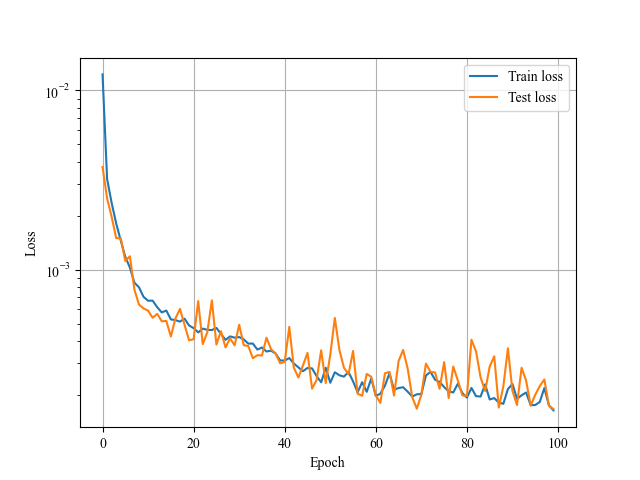

In [33]:
plot_loss(train_loss, test_loss)

#### Convex Neural Network

In [36]:
model = lrn.NeuralReachCvx(hidden_layers=hidden_layers).double()

train_loss, test_loss, model = train_reach(model, train_loader, test_loader, criterion, n_epochs=100, lr=lr, device=device)

out_dir = os.path.join(out_dir, "cvx_reach")
os.makedirs(out_dir)
save_model(model, "cvx_reach.pt", train_loss, test_loss, hidden_layers, lr, batch_size, train_data_rate, device, out_dir)

Epoch 1 | Train loss: 0.9125 | Test loss: 0.4821
Epoch 2 | Train loss: 0.3546 | Test loss: 0.2476
Epoch 3 | Train loss: 0.1905 | Test loss: 0.1395
Epoch 4 | Train loss: 0.1103 | Test loss: 0.0838
Epoch 5 | Train loss: 0.0696 | Test loss: 0.0562
Epoch 6 | Train loss: 0.0499 | Test loss: 0.0430
Epoch 7 | Train loss: 0.0413 | Test loss: 0.0380
Epoch 8 | Train loss: 0.0381 | Test loss: 0.0362
Epoch 9 | Train loss: 0.0371 | Test loss: 0.0359
Epoch 10 | Train loss: 0.0369 | Test loss: 0.0357
Epoch 11 | Train loss: 0.0369 | Test loss: 0.0356
Epoch 12 | Train loss: 0.0368 | Test loss: 0.0359
Epoch 13 | Train loss: 0.0369 | Test loss: 0.0357
Epoch 14 | Train loss: 0.0369 | Test loss: 0.0356
Epoch 15 | Train loss: 0.0369 | Test loss: 0.0357
Epoch 16 | Train loss: 0.0368 | Test loss: 0.0357
Epoch 17 | Train loss: 0.0368 | Test loss: 0.0359
Epoch 18 | Train loss: 0.0369 | Test loss: 0.0354
Epoch 19 | Train loss: 0.0368 | Test loss: 0.0353
Epoch 20 | Train loss: 0.0369 | Test loss: 0.0357
Epoch 21 

RuntimeError: File ../saved/controllable_set/reachset_train/20231115-025054\models_20231130-175526\cvx_reach\cvx_reach.pt cannot be opened.

In [37]:
out_dir = os.path.join(out_dir, "cvx_reach")
os.makedirs(out_dir)
save_model(model, "cvx_reach.pt", train_loss, test_loss, hidden_layers, lr, batch_size, train_data_rate, device, out_dir)

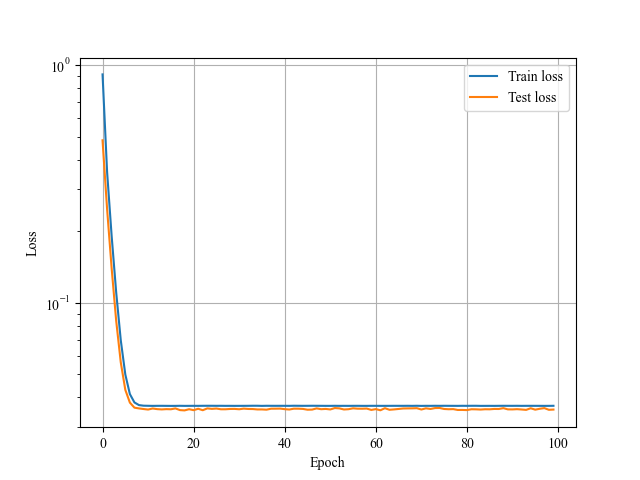

In [38]:
plot_loss(train_loss, test_loss)

# Learning Feasibility

In [181]:
feasibility_data = np.load(os.path.join(base_dir, "feasibility_data.npy"))
feasible_rate = np.sum(feasibility_data[:, 5]) / feasibility_data.shape[0]
print(f"Feasibility data size: {feasibility_data.shape[0]}, Feasible rate: {feasible_rate:.2f}, Infeasible rate: {1 - feasible_rate:.2f}")

# print bounds for each column
names = ["h", "vx", "vz", "m", "tgo", "feasibility"]
for i in range(feasibility_data.shape[1]):
        print(f"{names[i]}: [{np.min(feasibility_data[:, i]):.2f}, {np.max(feasibility_data[:, i]):.2f}]")

Feasibility data size: 176346, Feasible rate: 0.50, Infeasible rate: 0.50
h: [10.01, 1695.10]
vx: [-57.56, 57.56]
vz: [-99.95, 90.90]
m: [1527.04, 1904.60]
tgo: [8.85, 150.00]
feasibility: [0.00, 1.00]


In [182]:
feasibility_data[feasibility_data[:, 5] == 1, 0].shape

(88173,)

In [203]:
h = 1000.0
vx = 30.0
vz = -30.0
m = 1700.0
tgo = 60.0
print(f"Input: h={h}, vx={vx}, vz={vz}, m={m}, tgo={tgo}")
# sample feasibility data with the mean vx, vz, m
h_mask = (feasibility_data[:, 0] >= h * 0.99) & (feasibility_data[:, 0] <= h * 1.01)
vx_mask = (feasibility_data[:, 1] >= vx * 0.9) & (feasibility_data[:, 1] <= vx * 1.1)
vz_mask = (feasibility_data[:, 2] >= vz * 1.1) & (feasibility_data[:, 2] <= vz * 0.9)
m_mask = (feasibility_data[:, 3] >= m * 0.99) & (feasibility_data[:, 3] <= m * 1.1)
tgo_mask = (feasibility_data[:, 4] >= tgo * 0.99) & (feasibility_data[:, 4] <= tgo * 1.1)

#combined_mask = vx_mask & vz_mask & m_mask
combined_mask = h_mask  & vx_mask & vz_mask
feasibility_data_sample = feasibility_data[combined_mask, :]

print(f"Feasibility data sample size: {feasibility_data_sample.shape[0]}")

Input: h=1000.0, vx=30.0, vz=-30.0, m=1700.0, tgo=60.0
Feasibility data sample size: 7


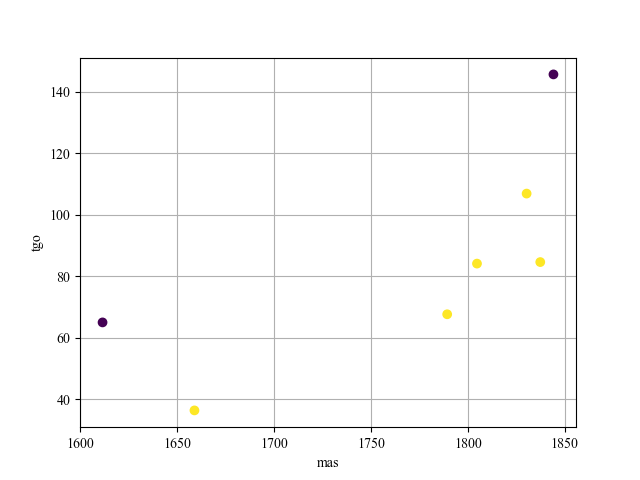

In [204]:
# scatter plot for feasibility data
fig, ax = plt.subplots()
ax.scatter(feasibility_data_sample[:, 3], feasibility_data_sample[:, 4], c=feasibility_data_sample[:, 5])
ax.set_xlabel("mas")
ax.set_ylabel("tgo")
ax.grid()
plt.show()



In [174]:
# define hyperparameters
train_data_rate = 0.95
batch_size = 4096

# create dataset and dataloader
dataset = lrn.FeasibilityDataset(reachset=feasibility_data)
n_data = len(dataset)
train_size = int(train_data_rate * n_data)
test_size = n_data - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

#### Multi-Layered Perceptron

In [175]:
def custom_loss(y_pred, y_true):
    fp_weight = 1.05  # weight for false positive
    fn_weight = 0.95  # weight for false negative
    loss = fn_weight * y_true * torch.log(y_pred) + fp_weight * (1 - y_true) * torch.log(1 - y_pred)
    return -torch.mean(loss)

print(f"Nominal Loss: {custom_loss(torch.Tensor([0.5, 0.5]), torch.Tensor([0.0, 1.0]))}")
print(f"False Positive Loss: {custom_loss(torch.Tensor([0.5]), torch.Tensor([0.0]))}")
print(f"False Negative Loss: {custom_loss(torch.Tensor([0.5]), torch.Tensor([1.0]))}")

Nominal Loss: 0.6931471824645996
False Positive Loss: 0.7278044819831848
False Negative Loss: 0.6584898233413696


In [179]:
lr = 1e-4
hidden_layers = [256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
#hidden_layers = [1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]
model = lrn.NeuralFeasibility(hidden_layers=hidden_layers)

criterion = custom_loss

train_loss, test_loss, model = train_reach(model, train_loader, test_loader, criterion, n_epochs=100, lr=lr, device=device)

out_dir = os.path.join(out_dir, "mlp_feas")
os.makedirs(out_dir)
save_model(model, "mlp_feas.pt", train_loss, test_loss, hidden_layers, lr, batch_size, train_data_rate, device, out_dir)

Epoch 1 | Train loss: 0.6953 | Test loss: 0.6932
Epoch 2 | Train loss: 0.6925 | Test loss: 0.6927


KeyboardInterrupt: 

In [ ]:
plot_loss(train_loss, test_loss)

In [160]:
criterion = custom_loss
model.eval()
with torch.no_grad():
    for _, x, y in test_loader:
        # move batch to device
        x = x.to(device)
        y = y.to(device)

        # forward
        y_hat = model(x)
        
        loss = criterion(y_hat, y)

        # randomply pick samples from batch and compare prediction with ground truth
        idx = np.random.randint(0, x.shape[0], 10)
        # print shapes of x, y, y_hat
        print(f"x shape: {x.shape}")
        print(f"y shape: {y.shape}")
        print(f"y_hat shape: {y_hat.shape}")

        for i in idx:
            print(f"Ground truth: {y[i]}, Prediction: {y_hat[i, :]}, Loss: {loss.item():.4f}")
            print("")

        # print loss
        print(f"Test loss: {loss.item():.4f}")

x shape: torch.Size([4096, 5])
y shape: torch.Size([4096])
y_hat shape: torch.Size([4096, 1])
Ground truth: 0.0, Prediction: tensor([0.4796], dtype=torch.float64), Loss: 0.6922

Ground truth: 0.0, Prediction: tensor([0.4781], dtype=torch.float64), Loss: 0.6922

Ground truth: 0.0, Prediction: tensor([0.4766], dtype=torch.float64), Loss: 0.6922

Ground truth: 0.0, Prediction: tensor([0.4711], dtype=torch.float64), Loss: 0.6922

Ground truth: 1.0, Prediction: tensor([0.4747], dtype=torch.float64), Loss: 0.6922

Ground truth: 1.0, Prediction: tensor([0.4772], dtype=torch.float64), Loss: 0.6922

Ground truth: 1.0, Prediction: tensor([0.4736], dtype=torch.float64), Loss: 0.6922

Ground truth: 1.0, Prediction: tensor([0.4743], dtype=torch.float64), Loss: 0.6922

Ground truth: 1.0, Prediction: tensor([0.4776], dtype=torch.float64), Loss: 0.6922

Ground truth: 1.0, Prediction: tensor([0.4762], dtype=torch.float64), Loss: 0.6922

Test loss: 0.6922
x shape: torch.Size([4096, 5])
y shape: torch.Si

#### Convex Neural Network

In [ ]:
model = lrn.NeuralFeasibilityCvx(hidden_layers=hidden_layers).double()

train_loss, test_loss, model = train_reach(model, train_loader, test_loader, criterion, n_epochs=100, lr=lr, device=device)

out_dir = os.path.join(out_dir, "cvx_feas")
os.makedirs(out_dir)
save_model(model, "cvx_feas.pt", train_loss, test_loss, hidden_layers, lr, batch_size, train_data_rate, device, out_dir)

In [ ]:
plot_loss(train_loss, test_loss)